In [40]:
import torch
import torchvision

In [41]:
print(torch.__version__)
print(torchvision.__version__)

1.11.0+cu113
0.12.0+cu113


In [42]:
# import matplotlib
# matplotlib.use('TkAgg')

In [43]:
import matplotlib.pyplot as plt

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import sys

sys.path.append('..')
sys.path.append('../examples')

# Data Loading

First, let's take a look at how to load our dataset in the format that Yolov7 expects.

## Selecting a dataset

Throughout this article, we shall use the [Kaggle cars object detection dataset](https://www.kaggle.com/datasets/sshikamaru/car-object-detection); however, as our aim is to demonstrate how Yolov7 can be applied to any problem, this is really the least important part of this work. Additionally, as the images are quite similar to COCO, it will enable us to experiment with a pretrained model before we do any training.


In [46]:
from pathlib import Path
import os
import pandas as pd

In [48]:
data_path = "../data/papilla/anatomical-model-papilla-yolo-export-v1_dheeraj"
data_path = Path(data_path)
images_path = data_path / "Aslanian_Exalt_1_images" # all_images
annotations_file_path = data_path / "output_coco_annotations.json" # annotations_final.csv

In [49]:
str(images_path).split("\\")[-1]

'Aslanian_Exalt_1_images'

As it is not usually the case that all images in our dataset contain instances of the objects that we are trying to detect, we would also like to include some images that do not contain cars. To do this, we can define a function to load the annotations which also includes 100 'negative' images. Additionally, as the designated test set is unlabelled, let's randomly take 20% of these images to use as our validation set. 

## Crop the images and Saving into a folder

In [10]:
import cv2

images_list= os.listdir(images_path)## Creatng list of images from the actual image directory
print(f"Number of Images:{len(images_list)}")
# Verify coordinate values--> Change these values according to the image
####(tip- can use paint app to find the xmin,ymin,xmax,ymax)

xmin = 560  # example xmin value
ymin = 60  # example ymin value
xmax = 1680  # example xmax value
ymax = 1027  # example ymax value

images_list = os.listdir(images_path)
## Defining the directory for croped images
cropped_images_dir  = data_path / str("cropped_images-of-"+str(images_path).split("\\")[-1]) 

if not os.path.exists(cropped_images_dir):
    os.makedirs(cropped_images_dir)
    print(f"Created directory: {cropped_images_dir}")
    
    for image_name in images_list:
        # Load the image
        image_path = images_path / image_name
        
        image = cv2.imread(str(image_path))

        # Perform cropping
        cropped_image = image[ymin:ymax, xmin:xmax]
        # Save the cropped image
        cropped_image_path = cropped_images_dir / image_name
        cv2.imwrite(str(cropped_image_path), cropped_image)
#         print(f"Cropped image saved: {cropped_image_path}")
#         break  # Uncomment this line if you want to crop only the first image for testing purposes

else:
    print(f"Directory already exists: {cropped_images_dir}")


Number of Images:1760
Directory already exists: ..\data\papilla\anatomical-model-papilla-yolo-export-v1_dheeraj\cropped_images-of-Aslanian_Exalt_1_images


## Reading the Json file and creating the data frame

In [11]:
# Load the annotations from the JSON file
import json
with open(annotations_file_path, 'r') as f:
        data = json.load(f)

# REmoving segmentation, area, iscrowd, extra keys from the annotations:
keys_to_remove = ['segmentation', 'area', 'iscrowd', 'extra']

for item in data['annotations']:
    for key in keys_to_remove:
        if key in item:
            del item[key]

In [12]:
data['categories']

[{'id': 3757286716, 'name': 'model_papilla', 'supercategory': 'root'}]

In [13]:
# Updating the Bounding boxes and Creating the Dataframe
import re
import numpy as np

annotations= data['annotations']        
my_images_list = os.listdir(data_path / "Aslanian_Exalt_1_images")

#Creating dataframe    

my_df= {'image':[], 'xmin':[],'ymin':[], 'xmax':[], 'ymax':[], 'class_name':[], 
        'has_annotation':[], 'image_id':[], 'class_id':[] }
# Iterate over the images
for image_filename in my_images_list:
    # Find the annotation for the current image filename
    new_image_filename = int(image_filename.split('.')[0])
#     mayching_data = next((annotation for annotation in annotations if annotation['image_id'] == new_image_filename), None)
    matching_data= [d for d in data['annotations'] if d['image_id']== new_image_filename]
    ## Inputting data into dictionary for the dataframe building
    my_df['image'].append(image_filename)
    my_df['image_id'].append(np.nan)
    
#     print(matching_data)
    
    if len(matching_data)==0:
        
        my_df['class_name'].append('background')
        my_df['class_id'].append(np.nan)
        my_df['has_annotation'].append(False)## Im assuming if its a background (category id 168) there is no annotation

        my_df['xmin'].append(np.nan)
        my_df['ymin'].append(np.nan)
        my_df['xmax'].append(np.nan)
        my_df['ymax'].append(np.nan)
        
        
    else:
        
        original_bbox= matching_data[0]['bbox']# The bbox is in the format [xmin, ymin, w, h]
        
        crop_width = xmax - xmin
        crop_height = ymax - ymin
        
        # Converting bbox according to the cropped image and converting the format to [xmin, ymin, xmax, ymax]
        new_xmin = max(0, original_bbox[0] - xmin)
        new_ymin = max(0, original_bbox[1] - ymin)
        new_xmax = min(crop_width, original_bbox[0] + original_bbox[2] - xmin)
        new_ymax = min(crop_height, original_bbox[1] + original_bbox[3] - ymin)

#         print(bbox)
        my_df['class_name'].append('papilla')
        my_df['class_id'].append(0.0)
        my_df['has_annotation'].append(True)
    
        my_df['xmin'].append(new_xmin)
        my_df['ymin'].append(new_ymin)
        my_df['xmax'].append(new_xmax)# The bounding boxes are in the format x,y,w,g, from coco annotater
        my_df['ymax'].append(new_ymax)# Hence converting w & h to xmax, ymax 
        
final_df=  pd.DataFrame.from_dict(my_df)
final_df.image_id= list(range(1, len(final_df)+1))
final_df

,image,xmin,ymin,xmax,ymax,class_name,has_annotation,image_id,class_id
0,0000060.png,NaN,NaN,NaN,NaN,background,False,1,NaN
1,0000061.png,NaN,NaN,NaN,NaN,background,False,2,NaN
2,0000062.png,NaN,NaN,NaN,NaN,background,False,3,NaN
3,0000063.png,NaN,NaN,NaN,NaN,background,False,4,NaN
4,0000064.png,NaN,NaN,NaN,NaN,background,False,5,NaN
...,...,...,...,...,...,...,...,...,...
1755,0001815.png,NaN,NaN,NaN,NaN,background,False,1756,NaN
1756,0001816.png,NaN,NaN,NaN,NaN,background,False,1757,NaN
1757,0001817.png,NaN,NaN,NaN,NaN,background,False,1758,NaN
1758,0001818.png,NaN,NaN,NaN,NaN,background,False,1759,NaN


In [50]:
temp_df= final_df.iloc[300:330]
temp_df

,image,xmin,ymin,xmax,ymax,class_name,has_annotation,image_id,class_id
300,0000360.png,478.000000,70.000000,932.00,535.00,papilla,True,301,0.0
301,0000361.png,446.000000,70.000000,880.00,507.00,papilla,True,302,0.0
302,0000362.png,429.000000,71.000000,868.00,495.00,papilla,True,303,0.0
303,0000363.png,450.000000,83.000000,875.00,495.00,papilla,True,304,0.0
304,0000364.png,465.000000,90.000000,878.00,493.00,papilla,True,305,0.0
305,0000365.png,474.000000,85.000000,881.00,485.00,papilla,True,306,0.0
306,0000366.png,505.000000,82.000000,898.00,465.00,papilla,True,307,0.0
307,0000367.png,508.000000,80.000000,898.00,459.00,papilla,True,308,0.0
308,0000368.png,515.000000,80.000000,901.00,458.00,papilla,True,309,0.0
309,0000369.png,527.500000,85.000000,903.00,459.50,papilla,True,310,0.0


In [51]:
# Visualization
from PIL import Image, ImageDraw
for i in temp_df.index.tolist():
    my_img_path= cropped_images_dir / temp_df.image[i]
    # Load the image
#     image_path = 'path/to/your/image.jpg'
    image = Image.open(my_img_path)

    # Create a drawing object
    draw = ImageDraw.Draw(image)

    # Define the BBox coordinates
    xmin, ymin, xmax, ymax = temp_df['xmin'][i], temp_df['ymin'][i], temp_df['xmax'][i], temp_df['ymax'][i]
    
    print(my_img_path)
    print(xmin, ymin, xmax, ymax)
    # Draw the bounding box rectangle
    draw.rectangle([(xmin, ymin), (xmax, ymax)], outline='red', width=2)

    # Show or save the image
    image.show()
    # image.save('path/to/save/image_with_bounding_box.jpg')
    break

..\data\papilla\anatomical-model-papilla-yolo-export-v1_dheeraj\cropped_images-of-Aslanian_Exalt_1_images\0000360.png
478.0 70.0 932.0 535.0


## Now continuing using the cropped image path and the annotation (dataframe)

In [53]:
import pandas as pd
import random

def load_cars_df(df):
    # all_images = sorted(set([p.parts[-1] for p in images_path.iterdir()]))
    image_id_to_image = {i: im for i, im in zip(df.image_id, df.image)}
    image_to_image_id = {v: k for k, v, in image_id_to_image.items()}
    
    class_id_to_label = dict(
        enumerate(df.query("has_annotation == True").class_name.unique())
    )
    class_label_to_id = {v: k for k, v in class_id_to_label.items()}
        
    from sklearn.model_selection import train_test_split
    # first, split into X_train, X_valid_test, y_train, y_valid_test
    # `test_size=0.3` split into 70% and 30%
    train_df, valid_test_df = train_test_split(df, test_size=0.3, random_state=42)

    # second, split into X_valid, X_test, y_valid, y_test
    # `test_size=0.5` split into 50% and 50%. The original data set is 30%,
    # so, it will split into 15% equally.
    valid_df, test_df = train_test_split(valid_test_df, test_size=0.5, random_state=42)

    lookups = {
        "image_id_to_image": image_id_to_image,
        "image_to_image_id": image_to_image_id,
        "class_id_to_label": class_id_to_label,
        "class_label_to_id": class_label_to_id,
    }
    return train_df, valid_df, test_df, lookups

We can now use this function to load our data:

In [54]:
train_df, valid_df, test_df, lookups = load_cars_df(final_df)

In [56]:
train_df.head()

,image,xmin,ymin,xmax,ymax,class_name,has_annotation,image_id,class_id
1188,0001248.png,480.000000,173.000000,839.000000,544.000000,papilla,True,1189,0.0
693,0000753.png,612.666667,130.333333,926.666667,490.333333,papilla,True,694,0.0
451,0000511.png,449.000000,158.000000,874.000000,582.000000,papilla,True,452,0.0
490,0000550.png,490.333333,186.515152,897.909091,598.787879,papilla,True,491,0.0
1698,0001758.png,NaN,NaN,NaN,NaN,background,False,1699,NaN


In [57]:
valid_df.head()

,image,xmin,ymin,xmax,ymax,class_name,has_annotation,image_id,class_id
941,0001001.png,488.454545,154.818182,823.636364,507.636364,papilla,True,942,0.0
1120,0001180.png,482.400000,228.200000,839.800000,601.400000,papilla,True,1121,0.0
843,0000903.png,467.888889,136.555556,826.555556,500.000000,papilla,True,844,0.0
1708,0001768.png,NaN,NaN,NaN,NaN,background,False,1709,NaN
937,0000997.png,491.333333,168.000000,825.666667,518.666667,papilla,True,938,0.0


In [58]:
test_df.head()

,image,xmin,ymin,xmax,ymax,class_name,has_annotation,image_id,class_id
651,0000711.png,577.500000,128.500000,907.000000,467.000000,papilla,True,652,0.0
609,0000669.png,594.500000,289.500000,945.000000,674.000000,papilla,True,610,0.0
1480,0001540.png,415.500000,121.468045,789.000000,500.500000,papilla,True,1481,0.0
629,0000689.png,602.384615,275.846154,970.076923,662.307692,papilla,True,630,0.0
754,0000814.png,424.800000,23.600000,792.400000,398.800000,papilla,True,755,0.0


In [59]:
print(train_df.image.nunique(), valid_df.image.nunique(), test_df.image.nunique())

1232 264 264


In [22]:
# train_df[train_df['class_name']=='no_papilla']

To make it easier to associate predictions with an image, we have assigned each image a unique id; in this case it is just an incrementing integer count. Additionally, we have added an integer value to represent the classes that we want to detect, which is a single class - 'car' - in this case.

Generally, object detection models reserve `0` as the background class, so class labels should start from `1`. This is **not** the case for Yolov7, so we start our class encoding from `0`. For images that do not contain a car, we do not require a class id. We can confirm that this is the case by inspecting the lookups returned by our function.

In [60]:
lookups.keys()

dict_keys(['image_id_to_image', 'image_to_image_id', 'class_id_to_label', 'class_label_to_id'])

In [61]:
lookups['class_label_to_id'], lookups['class_id_to_label']

({'papilla': 0}, {0: 'papilla'})

Finally, let's see the number of images in each class for our training and validation sets. As an image can have multiple annotations, we need to make sure that we account for this when calculating our counts:

In [62]:
print(f"Num. annotated images in training set: {len(train_df.query('has_annotation == True').image.unique())}")
print(f"Num. Background images in training set: {len(train_df.query('has_annotation == False').image.unique())}")
print(f"Total Num. images in training set: {len(train_df.image.unique())}")
print('------------')

print(f"Num. annotated images in validation set: {len(valid_df.query('has_annotation == True').image.unique())}")
print(f"Num. Background images in validation set: {len(valid_df.query('has_annotation == False').image.unique())}")
print(f"Total Num. images in validation set: {len(valid_df.image.unique())}")

Num. annotated images in training set: 997
Num. Background images in training set: 235
Total Num. images in training set: 1232
------------
Num. annotated images in validation set: 220
Num. Background images in validation set: 44
Total Num. images in validation set: 264


## Create a Dataset Adaptor

Usually, at this point, we would create a PyTorch dataset specific to the model that we shall be training. 

However, we often use the pattern of first creating a dataset 'adaptor' class, with the sole responsibility of wrapping the underlying data sources and loading this appropriately. This way, we can easily switch out adaptors when using different datasets, without changing any pre-processing logic which is specific to the model that we are training.

Therefore, let’s focus for now on creating a `CarsDatasetAdaptor` class, which converts the specific raw dataset format into an image and corresponding annotations. Additionally, let's load the image id that we assigned, as well as the height and width of our image, as they may be useful to us later on.

An implementation of this is presented below:

In [63]:
from train_cars import CarsDatasetAdaptor

Notice that, for our background images, we are just returning an empty array for our bounding boxes and class ids.

Using this, we can confirm that the length of our dataset is the same as the total number of training images that we calculated earlier.

In [64]:
# Make sure to plug in right variable for the path(images)
train_ds = CarsDatasetAdaptor(cropped_images_dir, train_df)
valid_ds= CarsDatasetAdaptor(cropped_images_dir, valid_df)
test_ds= CarsDatasetAdaptor(cropped_images_dir, test_df)

In [66]:
train_ds
for i in train_ds:
    print(i)
    break

(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), array([[480., 173., 839., 544.]]), array([0.]), 1189, (967, 1120))


Now, we can use this to visualise some of our images, as demonstrated below.

In [67]:
from yolov7.plotting import show_image

Let's wrap our data adaptor using this dataset and inspect some of the outputs:

### Transforms

In [69]:
from yolov7.dataset import Yolov7Dataset
from yolov7.dataset import create_yolov7_transforms

In [70]:
target_image_size = 640

In [71]:
train_yds = Yolov7Dataset(train_ds, transforms=create_yolov7_transforms(image_size=(target_image_size, target_image_size)))
eval_yds= Yolov7Dataset(valid_ds, transforms=create_yolov7_transforms(image_size=(target_image_size, target_image_size)))
test_yds= Yolov7Dataset(test_ds, transforms=create_yolov7_transforms(image_size=(target_image_size, target_image_size)))

Using these transforms, we can see that our image has been resized to our target size and padding has been applied. The reason that padding is used is so that we can maintain the aspect ratio of the objects in the images, but have a common size for images in our dataset; enabling us to batch them efficiently!

## Visualization

Image: torch.Size([3, 640, 640])
Labels: tensor([[0.0000, 0.0000, 0.5241, 0.3004, 0.3732, 0.3717]])


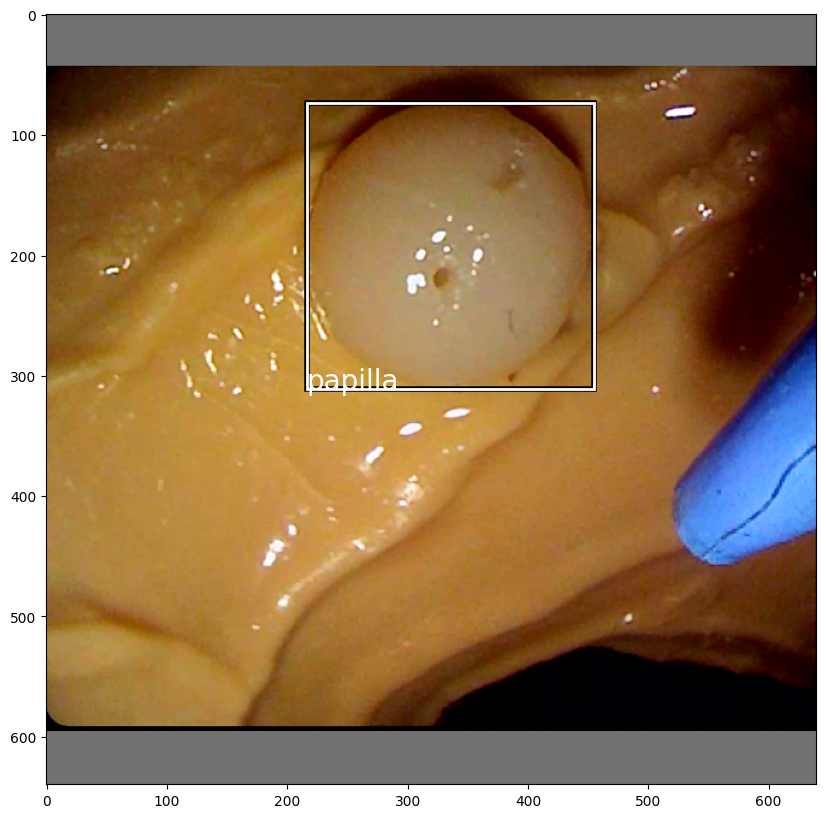

Image id: 817
Image size: tensor([ 967, 1120])


In [72]:
idx = 70
    
image_tensor, labels, image_id, image_size = train_yds[idx]

print(f'Image: {image_tensor.shape}')
print(f'Labels: {labels}')

# denormalize boxes
boxes = labels[:, 2:]
boxes[:, [0, 2]] *= target_image_size #image_size[1]## Multiplying with targetimagesize becasue, padding was applied (using transforms above)
boxes[:, [1, 3]] *= target_image_size #image_size[0]

show_image(image_tensor.permute( 1, 2, 0), boxes.tolist(), [lookups['class_id_to_label'][int(c)] for c in labels[:, 1]], 'cxcywh')
plt.show()
print(f'Image id: {image_id}')
print(f'Image size: {image_size}')

In [34]:
# train_df[train_df['class_name']=='no_papilla']

### Training from Scratch

In [73]:
from yolov7.trainer import Yolov7Trainer

In [36]:
# CHangint the path: this is the path wehre the trained weight (.pt) file is created
%cd "C:\Users\endo\Desktop\Yolov7-training-main\Yolov7-training-main\examples\"

C:\Users\endo\Desktop\Yolov7-training-main\Yolov7-training-main\examples


In [75]:
# Importing Necessary Libraries for training
import random
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from func_to_script import script
from PIL import Image
from pytorch_accelerated.callbacks import (
    ModelEmaCallback,
    ProgressBarCallback,
    SaveBestModelCallback,
    get_default_callbacks,
)
from pytorch_accelerated.schedulers import CosineLrScheduler
from torch.utils.data import Dataset

from yolov7 import create_yolov7_model
from yolov7.dataset import (
    Yolov7Dataset,
    create_base_transforms,
    create_yolov7_transforms,
    yolov7_collate_fn,
)
from yolov7.evaluation import CalculateMeanAveragePrecisionCallback
from yolov7.loss_factory import create_yolov7_loss
from yolov7.mosaic import MosaicMixupDataset, create_post_mosaic_transform
from yolov7.trainer import Yolov7Trainer, filter_eval_predictions
from yolov7.utils import SaveBatchesCallback, Yolov7ModelEma

# Training code

In [38]:
# Training from Scratch
DATA_PATH =data_path

def train_scratch(
    train_ds, valid_ds,
    data_path: str = DATA_PATH,
    image_size: int = 640,
    pretrained: bool = False,
    num_epochs: int = 50, #was 50
    batch_size: int = 8,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',# Add this line to set the device to use
):

##############################################################################
    # CHecking on which device the training is going to run
    print(device)
    #Code added by Mike: print name of GPU
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    
##############################################################################

# Defining Number of classes
    num_classes= 1
    
##############################################################################

    # Mosaic Augmentation
    mds = MosaicMixupDataset(
        train_ds,
        apply_mixup_probability=0.15,
        post_mosaic_transforms=create_post_mosaic_transform(
            output_height=image_size, output_width=image_size
        ),
    )
    
##############################################################################

    if pretrained:
        # disable mosaic if finetuning
        mds.disable()
        print('Mosaic Disabled')

##############################################################################
    # Creating the Yolo Transformed data 
    train_yds = Yolov7Dataset(
        mds,
        create_yolov7_transforms(training=True, image_size=(image_size, image_size)),
    )
    eval_yds = Yolov7Dataset( 
        valid_ds,
        create_yolov7_transforms(training=False, image_size=(image_size, image_size)),
    )
    
##############################################################################

    # create model, loss function and optimizer
    model = create_yolov7_model(
        architecture="yolov7", num_classes=num_classes, pretrained=pretrained
    ).to(device) # Moving the model to device
    
##############################################################################

    param_groups = model.get_parameter_groups()
    
##############################################################################

    loss_func = create_yolov7_loss(model, image_size=image_size)
    
##############################################################################

    optimizer = torch.optim.SGD(
        param_groups["other_params"], lr=0.01, momentum=0.937, nesterov=True
    )
    
##############################################################################

    # create evaluation callback and trainer
    calculate_map_callback = (
        CalculateMeanAveragePrecisionCallback.create_from_targets_df(
            targets_df=valid_df.query("has_annotation == True")[
                ["image_id", "xmin", "ymin", "xmax", "ymax", "class_id"]
            ],
            image_ids=set(valid_df.image_id.unique()),
            iou_threshold=0.2,
        )
    )
    
##############################################################################

    trainer = Yolov7Trainer(
        model=model,
        optimizer=optimizer,
        loss_func=loss_func,
        filter_eval_predictions_fn=partial(
            filter_eval_predictions, confidence_threshold=0.01, nms_threshold=0.3
        ),
        callbacks=[
            calculate_map_callback,
            SaveBestModelCallback(watch_metric="map", greater_is_better=True),
            SaveBatchesCallback("./batches", num_images_per_batch=3),
            *get_default_callbacks(progress_bar=True),
        ],
    )
    
##############################################################################

    # calculate scaled weight decay and gradient accumulation steps
    total_batch_size = (
        batch_size * trainer._accelerator.num_processes
    )  # batch size across all processes

    nominal_batch_size = 64
    num_accumulate_steps = max(round(nominal_batch_size / total_batch_size), 1)
    base_weight_decay = 0.0005
    scaled_weight_decay = (
        base_weight_decay * total_batch_size * num_accumulate_steps / nominal_batch_size
    )

    optimizer.add_param_group(
        {"params": param_groups["conv_weights"], "weight_decay": scaled_weight_decay}
    )

##############################################################################

    # run training
    trainer.train(
        num_epochs=num_epochs,
        train_dataset=train_yds,
        eval_dataset=eval_yds,
        per_device_batch_size=batch_size,
        create_scheduler_fn=CosineLrScheduler.create_scheduler_fn(
            num_warmup_epochs=5,
            num_cooldown_epochs=5,
            k_decay=2,
        ),
        collate_fn=yolov7_collate_fn,
        gradient_accumulation_steps=num_accumulate_steps,
    )
##############################################################################
## NOTE##
# The mAP obtained here for the Validation set is when IoU is set for 0.2
# Difference between finetuning and training from scratch code:
# 1. Mosaic Augmentation is not applied in Finetuning
# 2. Optimizer: model.get_parameter_groups() in Training from scratch; model.parameters() in FInetuning


In [39]:
train_scratch(train_ds, valid_ds)

cuda
NVIDIA RTX A4000

Starting training run

Starting epoch 1


100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [02:46<00:00,  1.08s/it]



train_loss_epoch: 2.6554733747011654


  0%|                                                                                           | 0/33 [00:00<?, ?it/s]C:\Users\endo\anaconda3\envs\yolov7_custon\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:57<00:00,  1.74s/it]



map: 0.0

eval_loss_epoch: 21.32122802734375

Starting epoch 2


100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [02:32<00:00,  1.01it/s]



train_loss_epoch: 1.712184402075681


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.94it/s]



map: 0.0014378815734569035

eval_loss_epoch: 1.9817122690605395

Starting epoch 3


100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [02:23<00:00,  1.07it/s]



train_loss_epoch: 0.26481713867419726


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.27it/s]



map: 0.014344369296073238

eval_loss_epoch: 0.6822787721951803

Starting epoch 4


  0%|                                                                                          | 0/154 [00:00<?, ?it/s]

KeyboardInterrupt: 

The notable differences between the "Training from Scratch" and "Fine-tuning" scenarios in the provided script:

Fine-tuning the model:

Dataset: The script defines train_yds and eval_yds using the Yolov7Dataset and create_yolov7_transforms functions for both training and evaluation datasets.

Optimizer: The optimizer is created using model.parameters() instead of model.get_parameter_groups().
Early Stopping: The script includes the EarlyStoppingCallback in the list of trainer callbacks, which helps stop training early if the metric does not improve.

No Gradient Accumulation Steps: Unlike the "Training from Scratch" script, there is no calculation or mention of gradient accumulation steps in the "Fine-tuning" script.

### Calculating mAP, Precision and Recall on Test set

##### I have created my own code for calculation of mAP, Precison, Recall, and Precision-Recall Curve
##### But this might not be necessary if we can use the functions provided in the evaluation folder correctly
##### Path for evaluation folder: C:\Users\endo\Desktop\Yolov7-training-main\Yolov7-training-main\yolov7\evaluation
##### Some idea on how to use it can be learnt from the above cell (Training Code), where the callbacks for calcualtion mAP were used

In [ ]:
# Defining model 
best_model = create_yolov7_model('yolov7', num_classes=1)
best_model.eval();

In [ ]:
# Loading Weights
# Remember to change the .pt file as per the trained weights you have or want to test with
best_model_path= 'C:\\Users\\endo\\Desktop\\Yolov7-training-main\\Yolov7-training-main\\examples\\model_weights_V7_annotations.pt'
checkpoint = torch.load(best_model_path)
state_dict = checkpoint['model_state_dict']
best_model.load_state_dict(state_dict)

## Running inference on test_yds

In [ ]:
import torch
for idx in range(len(test_yds)):
    image_tensor, labels, image_id, image_size = test_yds[idx]
    with torch.no_grad():
        model_outputs = best_model(image_tensor[None])
        preds = best_model.postprocess(model_outputs, conf_thres=0., multiple_labels_per_box=False)

        # Inference
        nms_predictions = filter_eval_predictions(preds, confidence_threshold=0.1)
        nms_predictions[0].shape
        pred_boxes = nms_predictions[0][:, :4]
        class_ids = nms_predictions[0][:, -1]

        show_image(image_tensor.permute( 1, 2, 0), pred_boxes.tolist(), class_ids.tolist())
        plt.show()
        print(preds)
#         print(f'Image id: {image_id}')
#         print(f'Original Image size: {image_size}')
#         print(f'Resized Image size: {image_tensor.shape[1:]}')

In [ ]:
def intersection_over_union(boxes_preds, boxes_labels, box_format= "corners"):
    # (N,4): N--number of bboxes
    # boxes_labels shape is (N,4)
    
    '''Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct Labels of Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
        '''       
    if box_format == "corners":
        
        #Converting cx,cy,w,h (center_x, center_y,w,h) into (xmin, ymin, xmax, ymax)
        
#         print(boxes_labels)
#         print(boxes_preds)
        
        center_x= boxes_labels[..., 0:1]
        center_y = boxes_labels[..., 1:2] 
        width = boxes_labels[..., 2:3] 
        height= boxes_labels[..., 3:4] 
        new_boxes_labels = torch.zeros_like(boxes_labels) # Initializing the tensor

        new_boxes_labels[..., 0:1]= center_x - (width / 2)
        new_boxes_labels[..., 1:2]= center_y - (height / 2)
        new_boxes_labels[..., 2:3]= center_x + (width / 2)
        new_boxes_labels[..., 3:4]= center_y + (height / 2)        
        
        
        pred_xmin= boxes_preds[..., 0:1]
        pred_ymin= boxes_preds[..., 1:2]
        pred_xmax= boxes_preds[..., 2:3]
        pred_ymax= boxes_preds[..., 3:4]

        label_xmin= new_boxes_labels[..., 0:1]
        label_ymin= new_boxes_labels[..., 1:2]
        label_xmax= new_boxes_labels[..., 2:3]
        label_ymax= new_boxes_labels[..., 3:4]

    inter_area = max(0, min(pred_xmax, label_xmax) - max(pred_xmin, label_xmin)) * \
             max(0, min(pred_ymax, label_ymax) - max(pred_ymin, label_ymin))

    pred_area = (pred_xmax - pred_xmin) * (pred_ymax - pred_ymin)
    label_area = (label_xmax - label_xmin) * (label_ymax - label_ymin)
    union_area = pred_area + label_area - inter_area

    iou = inter_area / union_area
    conf= boxes_preds[...,4:5]
    return iou, conf
        

In [ ]:
# Validation Image
df_list=[]
iou_thres= 0.5
for i in range(len(test_df)):
    
    # Taking a test image
    image_tensor, labels, image_id, image_size = test_yds[i]
    boxes_labels = labels[:, 2:]
    boxes_labels[:, [0, 2]] *= target_image_size
    boxes_labels[:, [1, 3]] *= target_image_size
    
    # Predicting 
    with torch.no_grad():
        model_outputs = best_model(image_tensor[None])
        preds = best_model.postprocess(model_outputs, conf_thres=0., multiple_labels_per_box=False)  
        
    # This has the bounding boxes with confidence and class label
    nms_predictions = filter_eval_predictions(preds, confidence_threshold=0.1)
    data= {'image_id':[],'gt_flag':[],'pd_flag':[], 'confidence':[], 'iou':[], 'tp':[], 'fp':[], 'fn':[], 'tn':[]}
    
    
    # Chec if the Ground Truth Bbox is available:
    if boxes_labels.numel()==0:
        # Now check if Predicted Bounding boxes are zero or any got predicted:
        if nms_predictions[0].numel()==0:
#             print(" We dont care about this case")
            data['image_id']= image_id.tolist()
            data['gt_flag'].append(1)
            data['pd_flag'].append(1)
            data['confidence'].append(np.nan)
            data['iou'].append(np.nan)
            data['tp'].append(np.nan)
            data['fn'].append(np.nan)
            data['fp'].append(np.nan)
            data['tn'].append(1)
        elif nms_predictions[0].numel()!=0:
            data['image_id']= image_id.tolist()
            data['gt_flag'].append(1)
            data['pd_flag'].append(0)
            data['confidence'].append(np.nan)
            data['iou'].append(np.nan)
            data['tp'].append(np.nan)
            data['fn'].append(np.nan)
            data['fp'].append(1)
            data['tn'].append(np.nan)
    # this is when the ground truth bounding box is available:
    else:
        # Now we chck if the prediction are done or not:
        # Checking if there are no predictions:
        if nms_predictions[0].numel()==0:
            data['image_id']= image_id.tolist()
            data['gt_flag'].append(0)
            data['pd_flag'].append(1)
            data['confidence'].append(np.nan)
            data['iou'].append(np.nan)
            data['tp'].append(np.nan)
            data['fn'].append(1)
            data['fp'].append(np.nan)
            data['tn'].append(np.nan)
        # Checking ig the prediction is done
        elif nms_predictions[0].numel()!=0:
            # In this case we check for IOU:
            # First we check of the number of predictions are 1 or more:
#             my_iou_list=[]
#             confidence= []
            
            if len(nms_predictions[0])>1:
                for j in range(len(nms_predictions[0])):
                    my_iou, conf= intersection_over_union(nms_predictions[0][j], boxes_labels, box_format= "corners")
#                     print(conf)
                    if my_iou> iou_thres:
                        data['image_id']= image_id.tolist()
                        data['gt_flag'].append(0)
                        data['pd_flag'].append(0)
                        data['confidence'].append(conf[0].tolist())
                        data['iou'].append(my_iou[0][0].tolist())
                        data['tp'].append(1)
                        data['fn'].append(np.nan)
                        data['fp'].append(np.nan)
                        data['tn'].append(np.nan)
                    else:
                        data['image_id']= image_id.tolist()
                        data['gt_flag'].append(0)
                        data['pd_flag'].append(0)
                        data['confidence'].append(conf[0].tolist())
                        data['iou'].append(my_iou[0][0].tolist())
                        data['tp'].append(np.nan)
                        data['fn'].append(np.nan)
                        data['fp'].append(1)
                        data['tn'].append(np.nan)
                        
#                     my_iou_list.append(my_iou)
#                     confidence.append(conf)
                
            else:
                
                my_iou, conf= intersection_over_union(nms_predictions[0], boxes_labels, box_format= "corners")
                
#                 print(conf)
                
                if my_iou> iou_thres:
                    data['image_id']= image_id.tolist()
                    data['gt_flag'].append(0)
                    data['pd_flag'].append(0)
                    data['confidence'].append(conf[0][0].tolist())
                    data['iou'].append(my_iou[0][0].tolist())
                    data['tp'].append(1)
                    data['fn'].append(np.nan)
                    data['fp'].append(np.nan)
                    data['tn'].append(np.nan)
                else:
                    data['image_id']= image_id.tolist()
                    data['gt_flag'].append(0)
                    data['pd_flag'].append(0)
                    data['confidence'].append(conf[0][0].tolist())
                    data['iou'].append(my_iou[0][0].tolist())
                    data['tp'].append(np.nan)
                    data['fn'].append(np.nan)
                    data['fp'].append(1)
                    data['tn'].append(np.nan)
#                 my_iou_list.append(my_iou)
#                 confidence.append(conf)

    df= pd.DataFrame(data)
#     display(df)
    df_list.append(df)
#     break

In [ ]:
final_df= pd.concat(df_list).reset_index().drop(columns='index')

In [ ]:
final_df

In [ ]:
final_df_sort= final_df.sort_values('confidence', ascending=False).reset_index().drop(columns='index')

In [ ]:
final_df_sort['tp_fp_fn'] = np.where((final_df_sort['tp'] ==1.0) , 'TP', 
                        np.where((final_df_sort['fp'] ==1.0) , 'FP', 
                                 np.where((final_df_sort['tn'] ==1.0) , 'TN',
                                          np.where((final_df_sort['fn'] ==1.0) , 'FN', np.nan))))

###############################################

final_df_sort['tp'] = final_df_sort['tp_fp_fn'].apply(lambda x: 1 if x == 'TP' else 0)
final_df_sort['fp'] = final_df_sort['tp_fp_fn'].apply(lambda x: 1 if x == 'FP' else 0)
final_df_sort['fn'] = final_df_sort['tp_fp_fn'].apply(lambda x: 1 if x == 'FN' else 0)
final_df_sort['tn'] = final_df_sort['tp_fp_fn'].apply(lambda x: 1 if x == 'TN' else 0)


In [ ]:
final_df_sort

In [ ]:
from sklearn.metrics import auc

tp = np.cumsum(final_df_sort['tp_fp_fn'] == 'TP')
fp = np.cumsum(final_df_sort['tp_fp_fn'] == 'FP')
fn = np.sum(final_df_sort['tp_fp_fn'] == 'FN')

# Calculate precision and recall at each threshold
precision = tp / (tp + fp)
recall = tp / (tp + fn)

final_df_sort['precision']= precision
final_df_sort['recall']= recall
auc_pr = auc(final_df_sort['recall'], final_df_sort['precision'])

# Or can use the:
auc= torch.trapz(torch.tensor(final_df_sort['precision'].values), torch.tensor(final_df_sort['recall'].values))


In [ ]:
auc_pr, auc

In [ ]:
plt.plot(final_df_sort['recall'], final_df_sort['precision'])
plt.title('Precision vs Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

In [ ]:
auc

In [ ]:
TP = len(final_df_sort[final_df_sort['tp_fp_fn'] == 'TP'])
FP = len(final_df_sort[final_df_sort['tp_fp_fn'] == 'FP'])
FN = len(final_df_sort[final_df_sort['tp_fp_fn'] == 'FN'])
TN = len(final_df_sort[final_df_sort['tp_fp_fn'] == 'TN'])


In [ ]:
confusion_matrix = np.array([[TP, FP], [FN, TN]])
confusion_matrix